# Lab 3: Multi-Task Models 
Momin Irfan, Tyler Giallanza, Eric Smith, Oscar Vallner

## Setup for this lab

1. Download the data from the following link: https://smu.box.com/s/smqmwlef0yehpieicwxqdr99k7f9ru04
2. Extract the downloaded data into Lab3/data
3. Run the `query.py` script in the data folder
4. Install RDKit for Python: https://www.rdkit.org/docs/Install.html

NOTE: I found it significantly easier to download RDKit using the apt package for Ubuntu. However, this installed the Python2 version of RDKit instead of the Python3 version. If you are using Python3, the only difference is reading in the data using pickle.

In [1]:
import numpy as np
import pandas as pd
from rdkit import Chem, DataStructs
from rdkit.Chem import MACCSkeys, AllChem
from rdkit.Chem import ChemicalFeatures
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import RDConfig
import os
import pickle
from random import shuffle

import keras
from keras.layers import Input, Dense
from keras.models import Model


Using TensorFlow backend.


In [2]:
X = pickle.load(open('data/data.pkl','rb'))

In [3]:
df = pd.DataFrame.from_dict(X)#.head(200)
del X

In [4]:
# remove values in the middle
df = df[(df.ic50.astype(float) > 10000) | (df.ic50.astype(float) < 300)]

# binarize ic50
df.ic50 = df.ic50.astype(float) < 10000

In [5]:
def get_morgan_fingerprints(smiles):
    fdefName = os.path.join(RDConfig.RDDataDir,'BaseFeatures.fdef')
    factory = ChemicalFeatures.BuildFeatureFactory(fdefName)
    fps = []
    for smile in smiles:
        m = Chem.MolFromSmiles(smile)
        if m is not None:
            fps.append(AllChem.GetMorganFingerprintAsBitVect(m, 2, nBits=512))
        else:
            fps.append(None)
    return fps

def get_topological_fingerprints(smiles):
    fdefName = os.path.join(RDConfig.RDDataDir,'BaseFeatures.fdef')
    factory = ChemicalFeatures.BuildFeatureFactory(fdefName)
    fps = []
    for smile in smiles:
        m = Chem.MolFromSmiles(smile)
        if m is not None:
            fps.append(FingerprintMols.FingerprintMol(m))
        else:
            fps.append(None)
    return fps

In [ ]:
# build feature factory
fdefName = os.path.join(RDConfig.RDDataDir,'BaseFeatures.fdef')
factory = ChemicalFeatures.BuildFeatureFactory(fdefName)

#fps = []
#all_smiles = df.smiles
df['morgan_fps'] = get_morgan_fingerprints(df.smiles)
df['topological_fps'] = get_topological_fingerprints(df.smiles)
df = df[df.morgan_fps != None]
df = df.drop(columns=['smiles'])

In [ ]:
uq_targets = set(df.target)
target_data = {}
for target in uq_targets:
    target_data[target] = [[],[],[]]

for index, row in df.iterrows():
    try:
        morgan = np.zeros((1,))
        topo = np.zeros((1,))
        DataStructs.ConvertToNumpyArray(row.morgan_fps, morgan)
        DataStructs.ConvertToNumpyArray(row.topological_fps, topo)
        target_data[row.target][0].append(morgan)
        target_data[row.target][1].append(topo)
        targt_data[row.target][2].append(row.ic50)
    except:
        continue

for target in target_data.keys():
    target_data[target][0] = np.array(target_data[target][0])
    target_data[target][1] = np.array(target_data[target][1])
    target_data[target][2] = np.array(target_data[target][2])*1

In [ ]:
pickle.dump(target_data,open('target_data.pkl','wb'))

In [ ]:
!git add Lab3.ipynb
!git add target_data.pkl
!git commit -m "Add target data"
!git push

In [ ]:
!sftp -i ~/.ssh/mf2 -b sftp.txt tgiallanza@m2.smu.edu

The data is now saved in a dictionary called `target_data`. This dictionary contains one entry per target. For each target, there is a list that contains three values: a numpy array with the morgan fingerprints, a numpy array with the topological fingerprints, and a numpy array with the binary binding affinity.

In [20]:
def build_models(input_shape, target_names):
    model_input = Input(input_shape)
    shared_layers = Dense(512, activation='relu')(model_input)
    shared_layers = Dense(1024, activation='relu')(shared_layers)
    shared_layers = Dense(1024, activation='relu')(shared_layers)
    models = {}
    for target_name in target_names:
        specialized_layers = Dense(2048, activation='relu')(shared_layers)
        output = Dense(1, activation='sigmoid')(specialized_layers)
        models[target_name] = Model(model_input,output)
        models[target_name].compile(loss='binary_crossentropy',optimizer='adam')
    return models

def train_models(target_data, models, epochs, batch_size, data_type='morgan'):
    if data_type=='morgan':
        data_index = 0
    else:
        data_index = 1
    for epoch in range(epochs):
        target_order = models.keys()
        shuffle(target_order)
        for target in target_order:
            model = models[target]
            x_data = target_data[target][data_index]
            y_data = target_data[target][2]
            model.fit(x_data, y_data, batch_size=batch_size, epochs=1, verbose=0)

In [ ]:
#target_data[target_data.keys()[0]][0].shape

models = build_models((512,), target_data.keys())

train_models(target_data, models, 1, 2, 'morgan')

# Model Formation and Training

In the following section we take the data that we spit into different targets and filtered to 100 and further process it and build multi-task models

### Reading in the X and Y semi-raw data

In [1]:
import numpy as np

In [2]:
X = np.load('data/x_data.npy')

In [3]:
Y = np.load('data/y_data.npy')

# Refactoring and Fine Filtering Data

In [143]:
tasks = {}

for x,y in zip(X,Y):
    if y in tasks:
        tasks[y]['data'].append(np.array(x[2:]))
        tasks[y]['target'].append(x[0])
    else:
        tasks[y] = {}
        tasks[y]['data'] = [np.array(x[2:])]
        tasks[y]['target'] = [x[0]]


In [163]:
index = 1
top_targets = {}
for key, value in sorted(tasks.items(), key=lambda item: len(item[1]['target']), reverse=True):
    top_targets[key] = {}
    top_targets[key]['data'] = np.array(value['data'])
    top_targets[key]['target'] = np.array(value['target'])

    if index == 100:
        break
    index +=1 

### These are the top 100 targets that will be trained

In [164]:
print(list(top_targets))

['CHEMBL2114881', 'CHEMBL2114714', 'CHEMBL1963941', 'CHEMBL1963883', 'CHEMBL3562022', 'CHEMBL1614063', 'CHEMBL1738498', 'CHEMBL3881499', 'CHEMBL1614432', 'CHEMBL1613885', 'CHEMBL4028923', 'CHEMBL2218781', 'CHEMBL3880337', 'CHEMBL3880339', 'CHEMBL3880338', 'CHEMBL4028921', 'CHEMBL4028924', 'CHEMBL3705123', 'CHEMBL1613799', 'CHEMBL4028922', 'CHEMBL1738424', 'CHEMBL3880340', 'CHEMBL1738407', 'CHEMBL4017550', 'CHEMBL3706327', 'CHEMBL3880341', 'CHEMBL3436039', 'CHEMBL3436040', 'CHEMBL1614547', 'CHEMBL3436041', 'CHEMBL3431934', 'CHEMBL3880334', 'CHEMBL3880335', 'CHEMBL1614423', 'CHEMBL3880344', 'CHEMBL1964096', 'CHEMBL3431931', 'CHEMBL1964000', 'CHEMBL1614199', 'CHEMBL2114818', 'CHEMBL2114719', 'CHEMBL3880342', 'CHEMBL1963965', 'CHEMBL1119333', 'CHEMBL1614549', 'CHEMBL3734174', 'CHEMBL3887033', 'CHEMBL1614359', 'CHEMBL1006579', 'CHEMBL3707950', 'CHEMBL2114737', 'CHEMBL3882758', 'CHEMBL3215171', 'CHEMBL3883019', 'CHEMBL3882757', 'CHEMBL2114791', 'CHEMBL3214986', 'CHEMBL3707758', 'CHEMBL211474

In [167]:
from keras.layers import Input, Dense
from keras.models import Model
import time

inputs = Input(shape=(512,))
shared_mlp = Dense(64, activation='relu')(inputs)
shared_mlp = Dense(64, activation='relu')(shared_mlp)

# make a dictionary of models for each task
models_mtl = dict()
print('Creating Sub Models:')
og_start = time.time()
index = 1
for x in top_targets.keys():
    start = time.time()
    personal_layer = Dense(10, activation='relu')(shared_mlp)
    output_layer = Dense(1)(personal_layer)
    model = Model(inputs=inputs, outputs=output_layer)
    model.compile(optimizer='sgd', loss='mean_squared_error')
    models_mtl[x] = model
    end = time.time()
    
    print("Model: ", index, " | Section Time: ", end - start, " | Elapsed Time: ", end - og_start)
    index += 1

Creating Sub Models:
Model:  1  | Section Time:  0.0384061336517334  | Elapsed Time:  0.0384061336517334
Model:  2  | Section Time:  0.04989123344421387  | Elapsed Time:  0.08929610252380371
Model:  3  | Section Time:  0.062416791915893555  | Elapsed Time:  0.15171289443969727
Model:  4  | Section Time:  0.06698060035705566  | Elapsed Time:  0.21869349479675293
Model:  5  | Section Time:  0.06490254402160645  | Elapsed Time:  0.2835960388183594
Model:  6  | Section Time:  0.06194639205932617  | Elapsed Time:  0.34554243087768555
Model:  7  | Section Time:  0.062372446060180664  | Elapsed Time:  0.4079148769378662
Model:  8  | Section Time:  0.04922747611999512  | Elapsed Time:  0.45714235305786133
Model:  9  | Section Time:  0.053071022033691406  | Elapsed Time:  0.5112307071685791
Model:  10  | Section Time:  0.06298017501831055  | Elapsed Time:  0.5762863159179688
Model:  11  | Section Time:  0.06413722038269043  | Elapsed Time:  0.6404235363006592
Model:  12  | Section Time:  0.0510

Model:  98  | Section Time:  0.06615996360778809  | Elapsed Time:  6.925210475921631
Model:  99  | Section Time:  0.0662696361541748  | Elapsed Time:  6.991480112075806
Model:  100  | Section Time:  0.060849666595458984  | Elapsed Time:  7.052329778671265


## Creating the Train-Test Split

In [169]:
from sklearn.model_selection import train_test_split

test_size = 0.2

X_train = dict()
y_train = dict()
X_test = dict()
y_test = dict()

#print(top_targets[x][0])

for x in top_targets.keys():
    X_train[x], X_test[x], y_train[x], y_test[x] = train_test_split(top_targets[x]['data'], 
                                                        top_targets[x]['target'], 
                                                        test_size=test_size, 
                                                        random_state=42)


In [170]:
%%time
EPOCHS = 20
from random import shuffle

all_keys = list(top_targets)
for i in range(EPOCHS):
    print('Epoch',i,end=', ')
    shuffle(all_keys)
    for x in all_keys:
        models_mtl[x].fit(X_train[x],y_train[x], verbose=0)

Epoch 0, Epoch 1, Epoch 2, Epoch 3, Epoch 4, Epoch 5, Epoch 6, Epoch 7, Epoch 8, Epoch 9, Epoch 10, Epoch 11, Epoch 12, Epoch 13, Epoch 14, Epoch 15, Epoch 16, Epoch 17, Epoch 18, Epoch 19, Wall time: 6min 27s


# Evaluating the Train-Test Split Data

In [171]:
%%time
y_mtl=[]
yhat_mtl=[]

for x in X_test.keys():
    yhat_mlp = models_mtl[x].predict(X_test[x])

    y_mtl.append(y_test[x].ravel())
    yhat_mtl.append(yhat_mlp.ravel())

Wall time: 2min 42s


In [172]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_squared_error, accuracy_score 
from sklearn.metrics import precision_score, mean_squared_log_error

def bland_altman_plot(data1, data2, *args, **kwargs):
    data1     = np.asarray(data1)
    data2     = np.asarray(data2)
    mean      = np.mean([data1, data2], axis=0)
    diff      = data1 - data2                   # Difference between data1 and data2
    md        = np.mean(diff)                   # Mean of the difference
    sd        = np.std(diff, axis=0)            # Standard deviation of the difference

    plt.figure(figsize=(15,10))
    plt.scatter(mean, diff, *args, **kwargs)
    plt.axhline(md,           color='gray', linestyle='--')
    plt.axhline(md + 1.96*sd, color='gray', linestyle='--')
    plt.axhline(md - 1.96*sd, color='gray', linestyle='--')
    plt.title("Bland Altman, MSE: "+str(mean_squared_error(data1,data2)))
    plt.xlabel('Mean Score', fontsize=8)
    plt.ylabel('Diff Score', fontsize=8)
    plt.show()

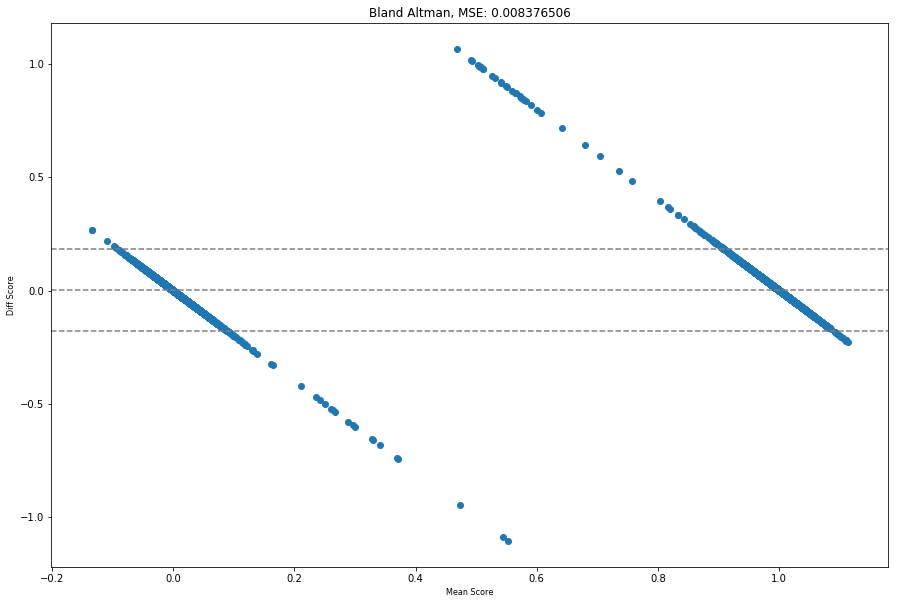

In [173]:

bland_altman_plot(np.concatenate(y_mtl), np.concatenate(yhat_mtl))

The following is a bland_altman plot of our models - as we can see the data is clustered around 1 and 0 (this makes sense because of our binary classification. We see a relatively narrow band around zero which is reassuring - but there do seeem to be a fair number of values that lie outside of the dotted lines (mostly incorrectly classified objects - which is why the left cluster is positive bound and the right cluster negatively). 

# Scoring the Results

In [13]:
from rdkit.ML.Scoring import Scoring

In [14]:
import pandas as pd

scores = {'y_mtl':np.concatenate(y_mtl), 'yhat_mtl':np.concatenate(yhat_mtl)}
df = pd.DataFrame(scores)

In [15]:
score_auc = Scoring.CalcAUC(df.values, 0)
print(score_auc)

0.3569572570198806


Looking at the AUC score, we can see that the performance of our model is very bad. With a score of 0.5 representing random chance, we can see that we are well below random chance in our outputs. This is very bad news for a classifier, as random chance should be a sanity check and the starting point from which a classifier improves. However since it is consistantly below random and the classification is binary we could look at alternative ways to extract data from this calssifier (inverse). More methods would be to add to our classifier

In [16]:
score_bedroc = Scoring.CalcBEDROC(df.values, 0, 20)
print(score_bedroc)

0.006959956243419538


The BEDROC metric is a modification of the ROC curve. This metric uses an alpha value to weight the probability distribution in which a random value is selected from. In our application, we used an alpha value of 20.

Looking at our results, our value is exceptionally poor. This is in line with the AUC representation that is given and leads us more to trying the modifications presented above

In [20]:
score_enrich = Scoring.CalcEnrichment(df.values, 0, [.01, .1, .25, .5])
print(score_enrich)

[0.0, 0.0, 0.21011197387585465, 0.7983050847457627]


The Enrichment factor represents the number of correctly classified ligands within a certain top percentage of the sample divided by the total sample. 
We ran the Enrichment scorer on a variety of values: 1%, 10%, 25%, and 50%. 
The values we got say that for the first 1% and 10% of samples, we got none of the ligands classified correctly. Then when we move to 25% and 50%, the values increase dramatically. This shows where we can focus a lot of our effort for following analysis. We also look to see if we could bring in more fingerprints to improve our model.

# Exceptional Work: Building another Multi-Task model with a different Fingerprint

For identifying the ligands there were both morgan and topolagical fingerprints availible in the dataset. We decided to use the other fingerprint in the following set to see if we could improve our results from above. 

### Reading in the X and Y semi-raw data

In [1]:
import numpy as np

In [2]:
X = np.load('data/x_data.npy')

In [3]:
Y = np.load('data/y_data.npy')

# Refactoring and Fine Filtering Data

In [4]:
tasks = {}

for x,y in zip(X,Y):
    if y in tasks:
        tasks[y]['data'].append(np.array(x[2:]))
        tasks[y]['target'].append(x[0])
    else:
        tasks[y] = {}
        tasks[y]['data'] = [np.array(x[2:])]
        tasks[y]['target'] = [x[0]]


In [5]:
print(tasks['CHEMBL664913']['target'])

[0.0, 1.0, 1.0, 1.0]


In [6]:
index = 1
top_targets = {}
for key, value in sorted(tasks.items(), key=lambda item: len(item[1]['target']), reverse=True):
    top_targets[key] = {}
    top_targets[key]['data'] = np.array(value['data'])
    top_targets[key]['target'] = np.array(value['target'])

    if index == 100:
        break
    index +=1 

### These are the top 100 targets that will be trained with this fingerprint

In [7]:
print(list(top_targets))

['CHEMBL3436040', 'CHEMBL2114791', 'CHEMBL830839', 'CHEMBL828662', 'CHEMBL2114781', 'CHEMBL1071424', 'CHEMBL886170', 'CHEMBL3431931', 'CHEMBL665590', 'CHEMBL3063318', 'CHEMBL811879', 'CHEMBL1614549', 'CHEMBL831965', 'CHEMBL665702', 'CHEMBL1786290', 'CHEMBL1005407', 'CHEMBL882590', 'CHEMBL3562078', 'CHEMBL1614547', 'CHEMBL763870', 'CHEMBL680373', 'CHEMBL3110679', 'CHEMBL1061354', 'CHEMBL897494', 'CHEMBL3436039', 'CHEMBL827820', 'CHEMBL889609', 'CHEMBL2061832', 'CHEMBL1290876', 'CHEMBL692692', 'CHEMBL868999', 'CHEMBL1837593', 'CHEMBL1963965', 'CHEMBL665602', 'CHEMBL1047162', 'CHEMBL865064', 'CHEMBL1062971', 'CHEMBL963281', 'CHEMBL665700', 'CHEMBL934050', 'CHEMBL910725', 'CHEMBL769364', 'CHEMBL889241', 'CHEMBL681800', 'CHEMBL884350', 'CHEMBL873739', 'CHEMBL811068', 'CHEMBL852974', 'CHEMBL914035', 'CHEMBL1013888', 'CHEMBL1738498', 'CHEMBL909462', 'CHEMBL762914', 'CHEMBL3865048', 'CHEMBL893278', 'CHEMBL1101183', 'CHEMBL1073069', 'CHEMBL1027390', 'CHEMBL664911', 'CHEMBL1291622', 'CHEMBL91641

In [9]:
from keras.layers import Input, Dense
from keras.models import Model
import time

inputs = Input(shape=(2048,))
shared_mlp = Dense(64, activation='relu')(inputs)
shared_mlp = Dense(64, activation='relu')(shared_mlp)

# make a dictionary of models for each task
models_mtl = dict()
print('Creating Sub Models:')
og_start = time.time()
index = 1
for x in top_targets.keys():
    start = time.time()
    personal_layer = Dense(10, activation='relu')(shared_mlp)
    output_layer = Dense(1)(personal_layer)
    model = Model(inputs=inputs, outputs=output_layer)
    model.compile(optimizer='sgd', loss='mean_squared_error')
    models_mtl[x] = model
    end = time.time()
    
    print("Model: ", index, " | Section Time: ", end - start, " | Elapsed Time: ", end - og_start)
    index += 1

Using TensorFlow backend.


Creating Sub Models:
Model:  1  | Section Time:  0.03954267501831055  | Elapsed Time:  0.03977155685424805
Model:  2  | Section Time:  0.03833723068237305  | Elapsed Time:  0.07825970649719238
Model:  3  | Section Time:  0.03869223594665527  | Elapsed Time:  0.11708593368530273
Model:  4  | Section Time:  0.03769207000732422  | Elapsed Time:  0.15548253059387207
Model:  5  | Section Time:  0.03921937942504883  | Elapsed Time:  0.19482779502868652
Model:  6  | Section Time:  0.03923511505126953  | Elapsed Time:  0.23420143127441406
Model:  7  | Section Time:  0.03904366493225098  | Elapsed Time:  0.2733798027038574
Model:  8  | Section Time:  0.03807473182678223  | Elapsed Time:  0.312241792678833
Model:  9  | Section Time:  0.1023719310760498  | Elapsed Time:  0.41473913192749023
Model:  10  | Section Time:  0.03952455520629883  | Elapsed Time:  0.4551379680633545
Model:  11  | Section Time:  0.039351463317871094  | Elapsed Time:  0.49464869499206543
Model:  12  | Section Time:  0.0386

Model:  99  | Section Time:  0.0397341251373291  | Elapsed Time:  4.186552047729492
Model:  100  | Section Time:  0.03919863700866699  | Elapsed Time:  4.225893020629883


## Creating the Train-Test Split

In [10]:
from sklearn.model_selection import train_test_split

test_size = 0.2

X_train = dict()
y_train = dict()
X_test = dict()
y_test = dict()

#print(top_targets[x][0])

for x in top_targets.keys():
    X_train[x], X_test[x], y_train[x], y_test[x] = train_test_split(top_targets[x]['data'], 
                                                        top_targets[x]['target'], 
                                                        test_size=test_size, 
                                                        random_state=42)


In [11]:
%%time
EPOCHS = 20
from random import shuffle

all_keys = list(top_targets)
for i in range(EPOCHS):
    print('Epoch',i,end=', ')
    shuffle(all_keys)
    for x in all_keys:
        models_mtl[x].fit(X_train[x],y_train[x], verbose=0)

Epoch 0, Epoch 1, Epoch 2, Epoch 3, Epoch 4, Epoch 5, Epoch 6, Epoch 7, Epoch 8, Epoch 9, Epoch 10, Epoch 11, Epoch 12, Epoch 13, Epoch 14, Epoch 15, Epoch 16, Epoch 17, Epoch 18, Epoch 19, CPU times: user 2min 1s, sys: 4.76 s, total: 2min 6s
Wall time: 1min 57s


# Evaluating the Train-Test Split Data

In [12]:
%%time
y_mtl=[]
yhat_mtl=[]

for x in X_test.keys():
    yhat_mlp = models_mtl[x].predict(X_test[x])

    y_mtl.append(y_test[x].ravel())
    yhat_mtl.append(yhat_mlp.ravel())

CPU times: user 1min 8s, sys: 1.33 s, total: 1min 10s
Wall time: 1min 8s


In [13]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_squared_error, accuracy_score 
from sklearn.metrics import precision_score, mean_squared_log_error

def bland_altman_plot(data1, data2, *args, **kwargs):
    data1     = np.asarray(data1)
    data2     = np.asarray(data2)
    mean      = np.mean([data1, data2], axis=0)
    diff      = data1 - data2                   # Difference between data1 and data2
    md        = np.mean(diff)                   # Mean of the difference
    sd        = np.std(diff, axis=0)            # Standard deviation of the difference

    plt.figure(figsize=(15,10))
    plt.scatter(mean, diff, *args, **kwargs)
    plt.axhline(md,           color='gray', linestyle='--')
    plt.axhline(md + 1.96*sd, color='gray', linestyle='--')
    plt.axhline(md - 1.96*sd, color='gray', linestyle='--')
    plt.title("Bland Altman, MSE: "+str(mean_squared_error(data1,data2)))
    plt.xlabel('Mean Score', fontsize=8)
    plt.ylabel('Diff Score', fontsize=8)
    plt.show()

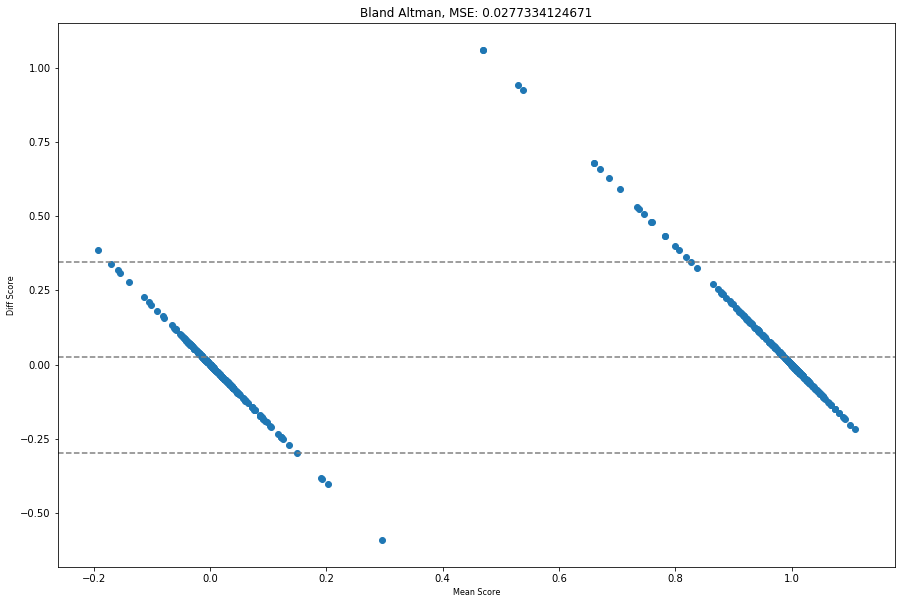

In [14]:

bland_altman_plot(np.concatenate(y_mtl), np.concatenate(yhat_mtl))

We see in this plot that we have a much tighter variance - this means that our model could learn more with this second fingerprint. Much more of the data is within the bands - our model performed far better with this new fingerprint.